# Stock Data Preprocessing

### Adding Project path to Sys Path

In [1]:
import os
import warnings
warnings.filterwarnings("ignore")
notebook_dir = os.getcwd()
parent_path=os.path.dirname(notebook_dir)

os.chdir(parent_path)

### Load Modules

In [2]:
from script.Preprocessing import Preprocessor
processor=Preprocessor()

### Download Stock Price Historical Data from Yahoo Finance
The following historical financial data for three key assets are fetched using `yfinance`
- **Tesla (TSLA) Historical stock prices**
- **Vanguard Total Bond Market ETF (BND)**
- **S&P 500 ETF (SPY)**

In [3]:
processor.dload_save_yfinance_data(tickers=['TSLA','BND','SPY'])

#Load the data from the saved csv
import pandas as pd
stoke_data=pd.read_csv("data/stoke_data.csv")
stoke_data.set_index('Date',inplace=True)
stoke_data.index=pd.to_datetime(stoke_data.index)
stoke_data.head()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,TSLA,BND,SPY
Date,,,
2015-01-02,14.620667,82.650002,205.429993
2015-01-05,14.006000,82.889999,201.720001
2015-01-06,14.085333,83.129997,199.820007
2015-01-07,14.063333,83.180000,202.309998
2015-01-08,14.041333,83.050003,205.899994


### Check missing Values

In [4]:
processor.check_missing(stoke_data)

TypeError: Preprocessor.check_missing() takes 1 positional argument but 2 were given

## Exploratory Data Analysis (EDA)

### Closing Price Over Time

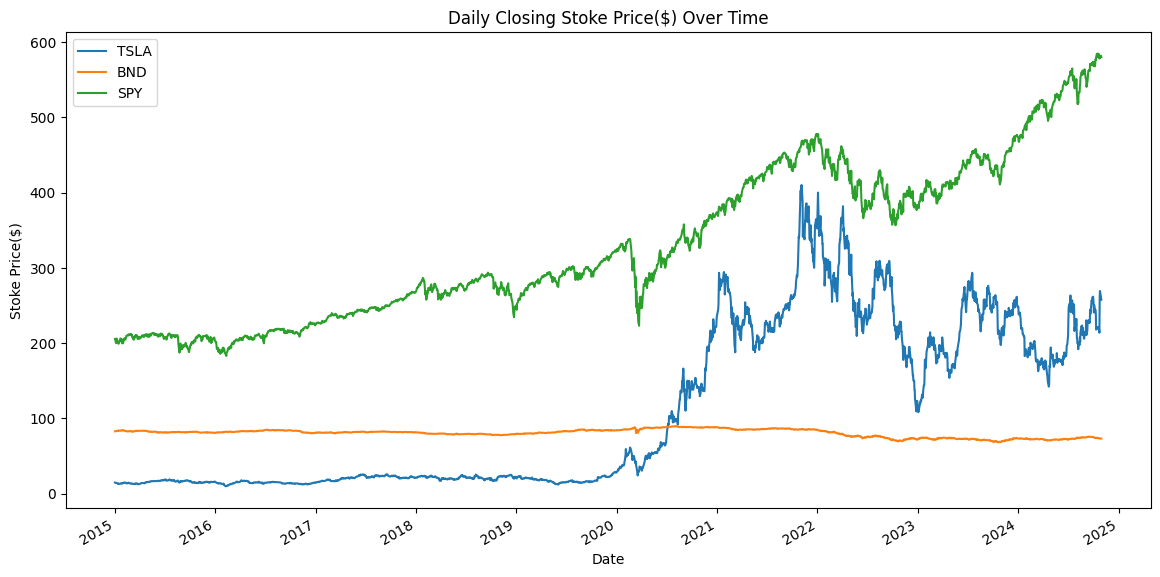

In [ ]:
processor.timeseries_plot(stoke_data)

### Daily Percentage Return 

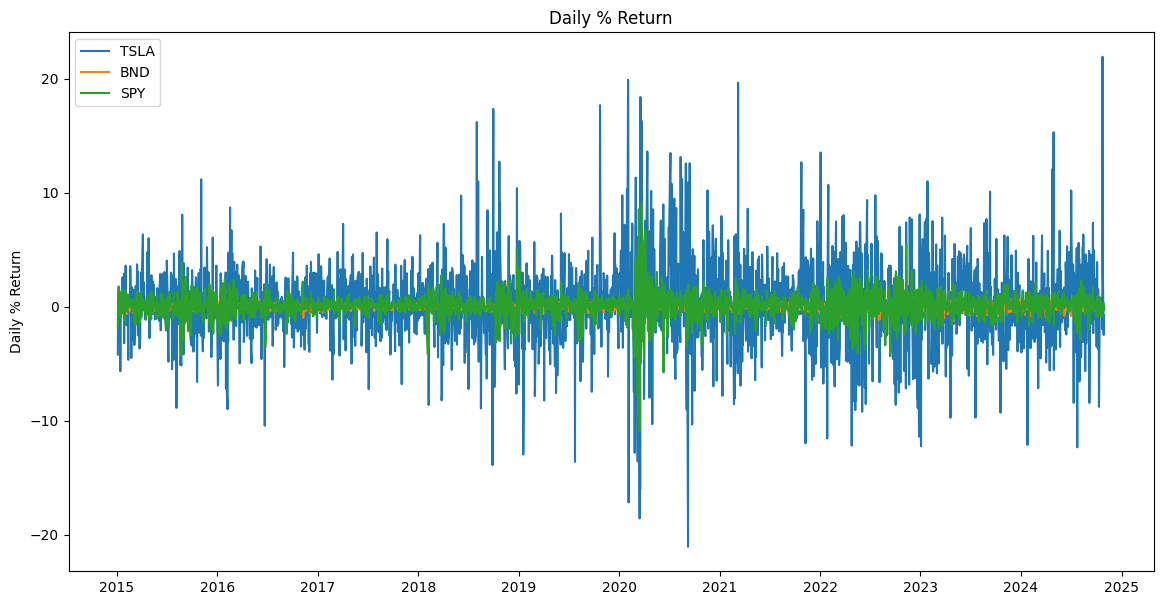

In [ ]:
import matplotlib.pyplot as plt



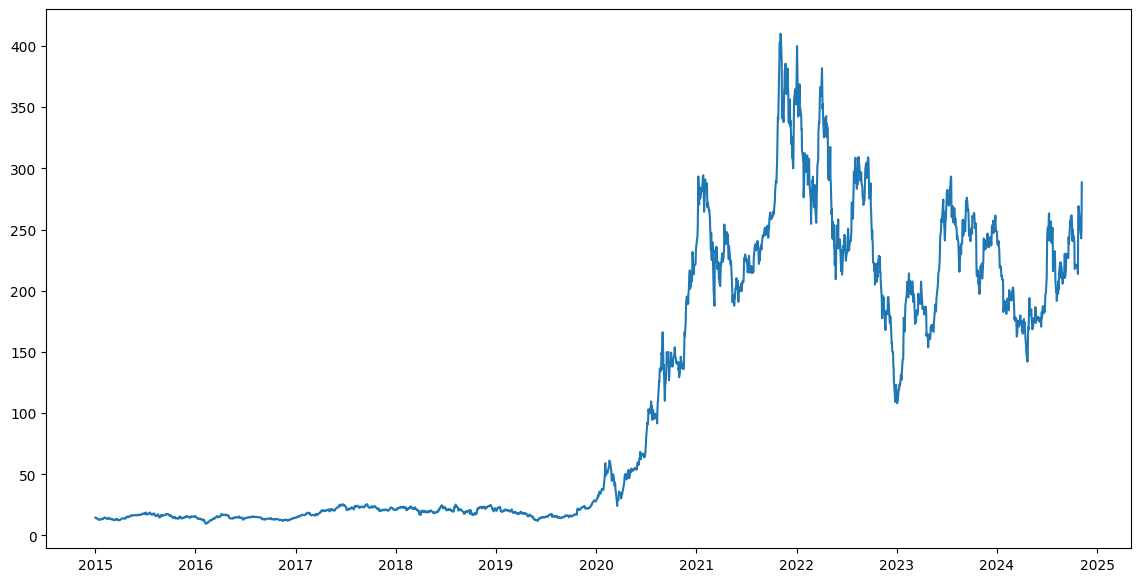

In [27]:
# TSLA_data.set_index('Date',inplace=True)
plt.figure(figsize=(14,7))
plt.plot(TSLA_data['Close'])
plt.show()

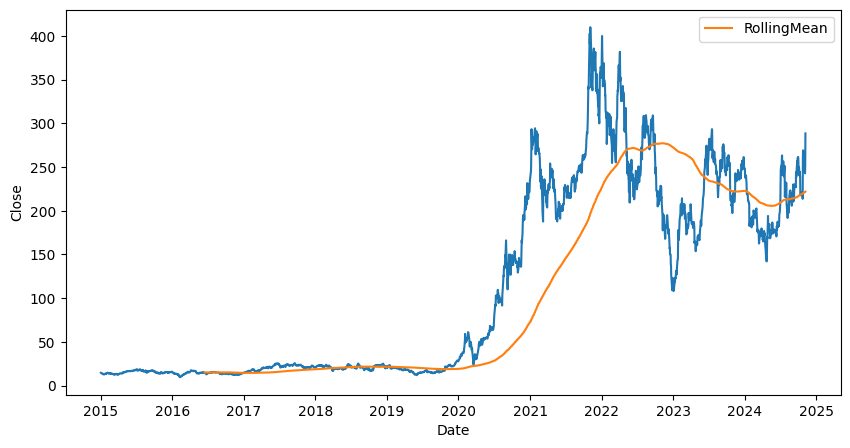

In [ ]:
import seaborn as sns
import numpy as np
# TSLA_data.index=pd.to_datetime(TSLA_data.index)
# TSLA_data['Close'] = pd.to_numeric(TSLA_data['Close'], errors='coerce')
TSLA_data["rollingMean"]=TSLA_data['Close'].rolling(window=365).mean()
plt.figure(figsize=(10,5))
sns.lineplot(TSLA_data,x=TSLA_data.index,y=TSLA_data['Close'])
sns.lineplot(TSLA_data,x=TSLA_data.index,y=TSLA_data["rollingMean"],label="RollingMean")
# y_min, y_max,step = 0, TSLA_data['Close'].max(),20
# plt.yticks(np.arange(y_min, y_max + step, step))
plt.legend()

Test Statistics: -1.0127942332637945
p-Value: 0.7485693426329318
Lag used: 27
Number of observation: 27
Critical Values': {'1%': np.float64(-3.433020812670638), '5%': np.float64(-2.8627199404827794), '10%': np.float64(-2.567398129768597)}
Conclusion: Non-Stationary


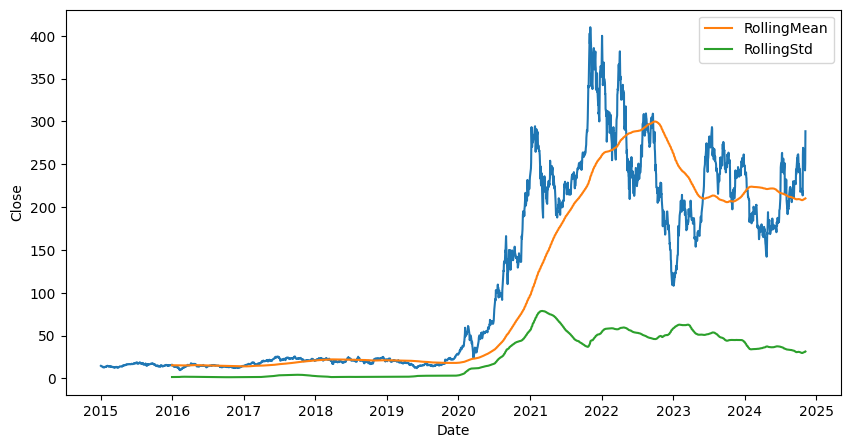

In [30]:
from statsmodels.tsa.stattools import adfuller
def check_stationarity(df,col):
    df["rollingMean"]=df[col].rolling(window=252).mean()
    df["rollingStd"]=df[col].rolling(window=252).std()
    result=adfuller(df[col],autolag="AIC")
    
    print(f"Test Statistics: {result[0]}")
    print(f"p-Value: {result[1]}")
    print(f"Lag used: {result[2]}")
    print(f"Number of observation: {result[2]}")
    print(f"Critical Values': {result[4]}")
    print(f"Conclusion: {'Stationary' if result[1] < 0.05 else 'Non-Stationary'}")
    
    plt.figure(figsize=(10,5))
    sns.lineplot(df,x=df.index,y=df[col])
    sns.lineplot(df,x=df.index,y=df["rollingMean"],label="RollingMean")
    sns.lineplot(df,x=df.index,y=df["rollingStd"],label="RollingStd")
    plt.legend()
    
check_stationarity(TSLA_data,'Close')

In [19]:
TSLA_data['Daily_percentage_change']=TSLA_data['Close'].pct_change()*100

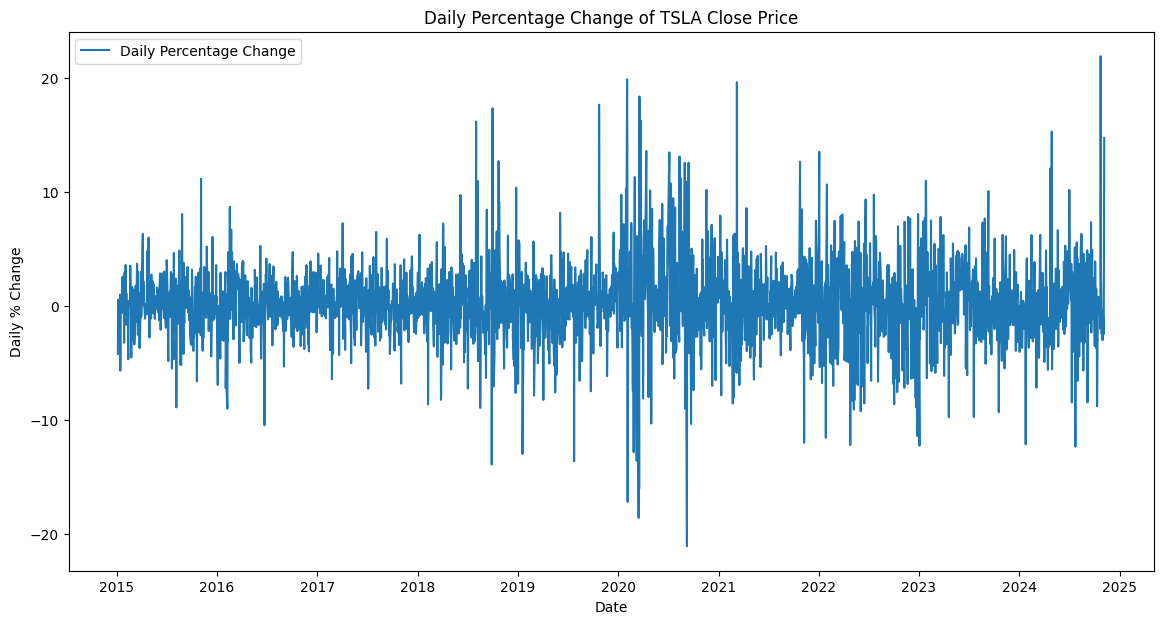

In [20]:
plt.figure(figsize=(14,7))
plt.plot(TSLA_data['Daily_percentage_change'],label="Daily Percentage Change")
plt.xlabel("Date")
plt.ylabel("Daily % Change")
plt.title("Daily Percentage Change of TSLA Close Price")
plt.legend()


In [31]:
import pandas as pd

# Calculate IQR for 'Close'
Q1 = TSLA_data['Close'].quantile(0.25)
Q3 = TSLA_data['Close'].quantile(0.75)
IQR = Q3 - Q1

# Define outlier bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Identify outliers in 'Close'
outliers_close = TSLA_data[(TSLA_data['Close'] < lower_bound) | (TSLA_data['Close'] > upper_bound)]

In [41]:
from scipy.stats import zscore
TSLA_data['Close_Z'] = zscore(TSLA_data['Close'].dropna())  # Drop NaN values for accurate z-scores

# Identify outliers (values with z-score > 3 or < -3)
outliers_close = TSLA_data[(TSLA_data['Close_Z'] > 2) | (TSLA_data['Close_Z'] < -2)]

In [52]:
outliers_close['Close'].idxmax(),outliers_close['Close'].idxmin(),

(Timestamp('2021-11-04 00:00:00'), Timestamp('2022-04-25 00:00:00'))

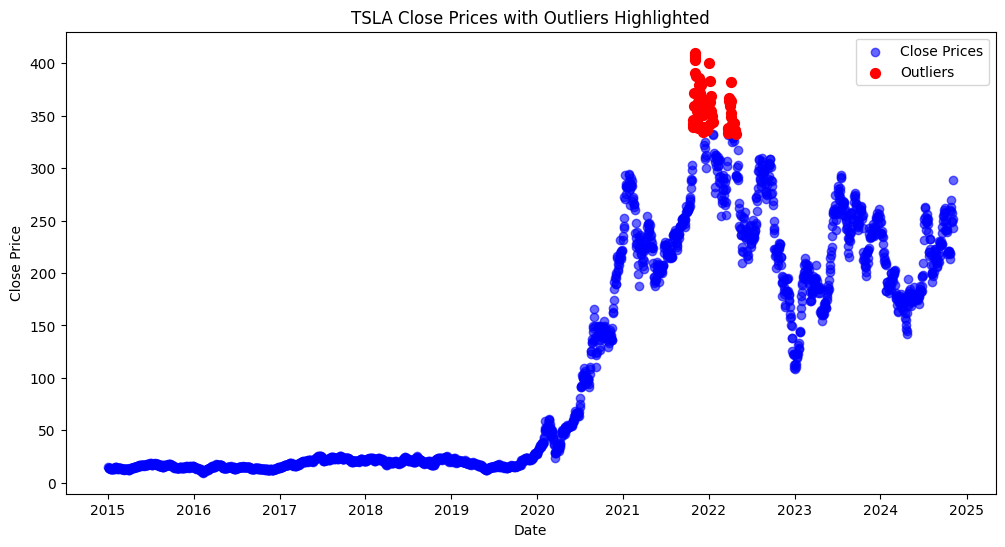

In [43]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot all Close prices
plt.scatter(TSLA_data.index, TSLA_data['Close'], color='blue', label='Close Prices', alpha=0.6)

# Plot outliers in a different color
plt.scatter(outliers_close.index, outliers_close['Close'], color='red', label='Outliers', marker='o', s=50)

# Add labels and title
plt.xlabel("Date")
plt.ylabel("Close Price")
plt.title("TSLA Close Prices with Outliers Highlighted")
plt.legend()

plt.show()


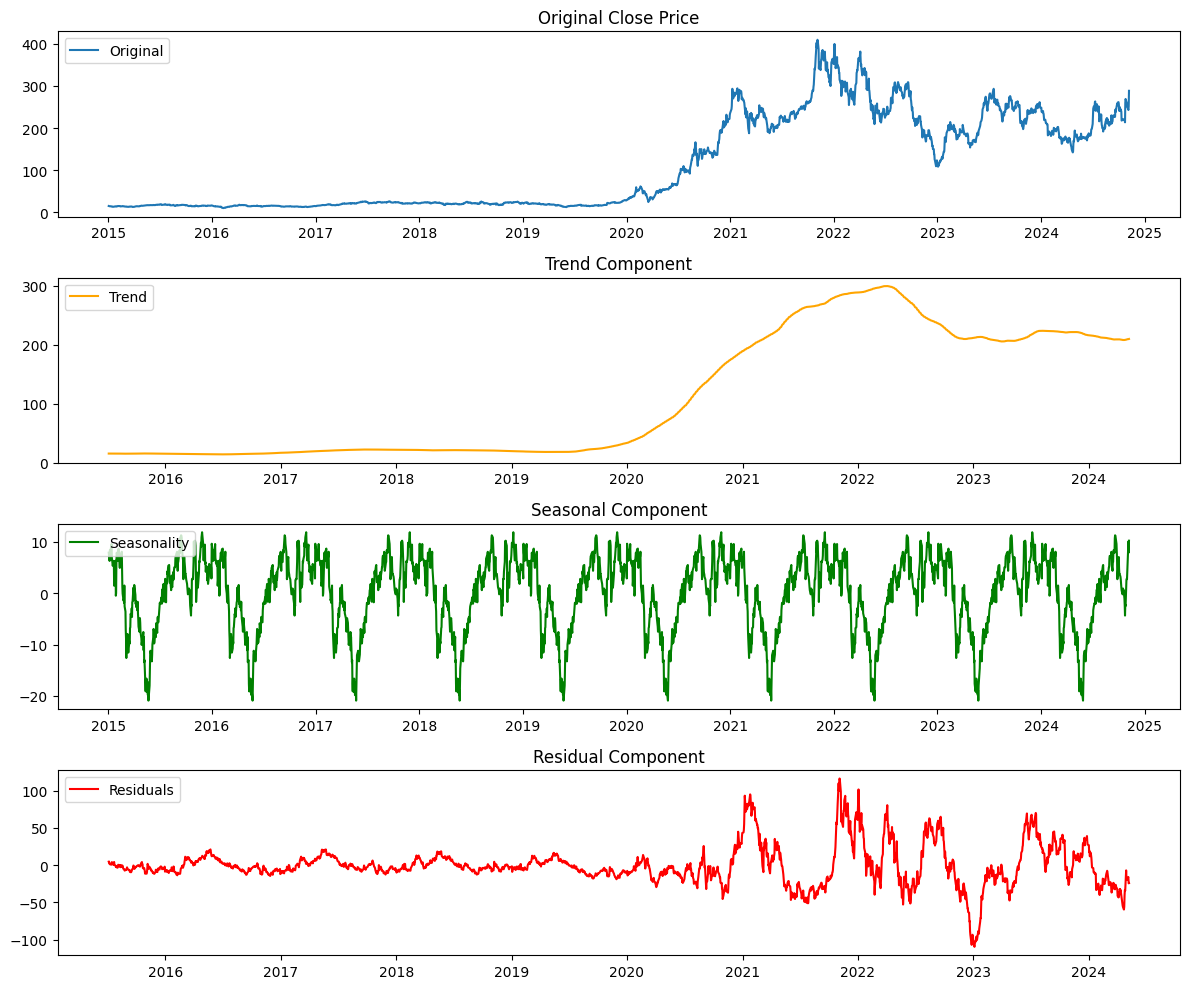

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(TSLA_data['Close'].dropna(), model='additive', period=252 )
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12, 10))

# Plot original data
plt.subplot(4, 1, 1)
plt.plot(TSLA_data['Close'], label='Original')
plt.legend(loc='upper left')
plt.title('Original Close Price')

# Plot trend
plt.subplot(4, 1, 2)
plt.plot(trend, label='Trend', color='orange')
plt.legend(loc='upper left')
plt.title('Trend Component')

# Plot seasonal
plt.subplot(4, 1, 3)
plt.plot(seasonal, label='Seasonality', color='green')
plt.legend(loc='upper left')
plt.title('Seasonal Component')

# Plot residuals
plt.subplot(4, 1, 4)
plt.plot(residual, label='Residuals', color='red')
plt.legend(loc='upper left')
plt.title('Residual Component')

plt.tight_layout()
plt.show()


### Fast Fourier Transform

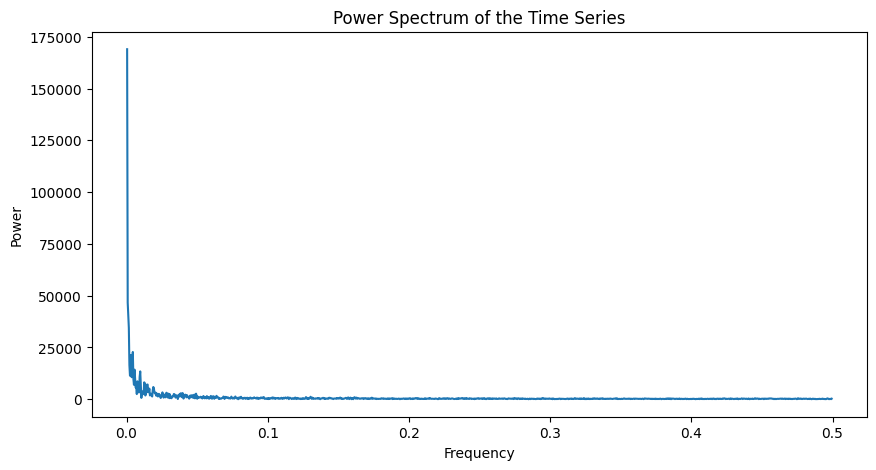

In [46]:
import numpy as np
import matplotlib.pyplot as plt

# Generate a sample time series (if not using an existing one)
# Suppose time_series is your data column (e.g., TSLA_data['Close'])
time_series = TSLA_data['Close'].dropna()  # Drop NaN values

# Perform Fourier Transform
fft_result = np.fft.fft(time_series)
fft_freq = np.fft.fftfreq(len(time_series))

# Calculate the power spectrum
power = np.abs(fft_result)

# Plot the power spectrum
plt.figure(figsize=(10, 5))
plt.plot(fft_freq[1:len(fft_freq)//2], power[1:len(power)//2])  # Exclude the zero frequency (DC component)
plt.xlabel("Frequency")
plt.ylabel("Power")
plt.title("Power Spectrum of the Time Series")
plt.show()


In [53]:
returns=TSLA_data['Close'].pct_change()*100

In [55]:
returns.describe()

count    2478.000000
mean        0.184582
std         3.590175
min       -21.062824
25%        -1.616814
50%         0.125835
75%         1.896632
max        21.919035
Name: Close, dtype: float64